# 📖 References

- https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb
- https://github.com/huggingface/notebooks/blob/main/examples/translation-tf.ipynb
- https://huggingface.co/gogamza/kobart-base-v2

# 0️⃣ Prerequisite

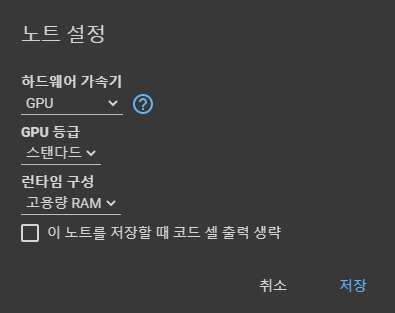

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 30 10:39:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
os.chdir('/content/drive/MyDrive/Study/Data Science/AI 자연어 처리 전문가 양성 과정 6기/Project 3')

In [4]:
!pip install -q datasets torchinfo transformers sacrebleu sentencepiece wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 118.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.7 MB/s eta 0:0

In [5]:
from datasets import Dataset, DatasetDict, load_dataset, load_metric
from easydict import EasyDict as edict
from sklearn.model_selection import train_test_split
from torchinfo import summary
from transformers import (
    AutoTokenizer,
    BartForConditionalGeneration,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback,
)

import numpy as np
import pandas as pd
import random
import sentencepiece
import torch

In [6]:
# Log in to your W&B account
import wandb

wandb.login(key='eeef6909a6674c953c756358e614461bdced83c4')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
def seed_everthing(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everthing(42)

# 1️⃣ Loading the dataset

In [ ]:
df_a = pd.read_csv('output/df_spoken-written_a.csv')
df_a.columns = ['id', 'spoken', 'written']

df_b = pd.read_csv('output/df_spoken-written_b.csv')
df_b.columns = ['id', 'spoken', 'written']

df = pd.concat([df_a, df_b])

In [ ]:
"""df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)
df_train.to_csv('input/df_spoken-written_train.csv', index=False)
df_validation.to_csv('input/df_spoken-written_validation.csv', index=False)"""

In [9]:
df_train = pd.read_csv('input/df_spoken-written_train.csv')
df_validation = pd.read_csv('input/df_spoken-written_validation.csv')

In [11]:
ds_train = Dataset.from_dict({'translation': df_train[['spoken', 'written']].to_dict('records')})
ds_validation = Dataset.from_dict({'translation': df_validation[['spoken', 'written']].to_dict('records')})

In [12]:
raw_datasets = DatasetDict({
    "train": ds_train,
    "validation": ds_validation})

In [13]:
print("Number of Train Samples:", len(raw_datasets['train']))
print("Number of Validation Samples:", len(raw_datasets['validation']))
print(raw_datasets['train'][0])
print(raw_datasets['validation'][0])

Number of Train Samples: 11012
Number of Validation Samples: 2754
{'translation': {'spoken': '차가 없어서 그러는데, 택시 외에 쇼핑센터로 가는 방법이 있나요?', 'written': '나는 차가 없지만 택시 외에 쇼핑 센터에 갈 수있는 방법이 있습니까?'}}
{'translation': {'spoken': '이 불고기 맛이 너무 환상적인데 어떻게 만드셨나요?', 'written': '이 불고기 맛은 매우 환상적입니다.어떻게 만들었습니까?'}}


In [15]:
del df_train, df_validation
del ds_train, ds_validation

import gc
gc.collect()

44

# 2️⃣ Preprocessing the data

In [16]:
model_checkpoint = 'gogamza/kobart-base-v2'

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [19]:
if 't5' in model_checkpoint:
    prefix = "translate Korean to Korean: "
else:
    prefix = ""

In [20]:
suffix = tokenizer.eos_token

In [21]:
max_input_length = 128
max_target_length = 128
source_lang = "spoken"
target_lang = "written"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] + suffix for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [22]:
preprocess_function(raw_datasets['train'][:2])

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [[20989, 23022, 14215, 15133, 19469, 18841, 18293, 14671, 10338, 16041, 20246, 21464, 17784], [18068, 14087, 26029, 28068, 14986, 19252, 16896, 14377, 16808, 16664, 14543]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[14651, 20989, 21280, 19469, 18841, 18293, 18627, 11786, 14640, 14032, 15583, 20246, 14026, 27927, 1], [14199, 14087, 17407, 15407, 14036, 14986, 17885, 16896, 14377, 22023, 20628, 1]]}

In [23]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

# 3️⃣ Fine-tuning the model

In [24]:
"""metric = load_metric("sacrebleu")"""

'metric = load_metric("sacrebleu")'

In [25]:
"""fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)"""

'fake_preds = ["hello there", "general kenobi"]\nfake_labels = [["hello there"], ["general kenobi"]]\nmetric.compute(predictions=fake_preds, references=fake_labels)'

In [26]:
model = BartForConditionalGeneration.from_pretrained(model_checkpoint)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [27]:
epochs = 30
batch_size = 16
accumulation = 4
seed = 42
model_name = model_checkpoint.split("/")[-1] + f"-finetuned-{source_lang}-to-{target_lang}-v2"

args = Seq2SeqTrainingArguments(
    model_name,
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=accumulation,
    weight_decay=0.01,
    num_train_epochs=epochs,
    logging_strategy='epoch',
    save_strategy='epoch',
    seed=seed,
    fp16=True,
    #predict_with_generate=True,
    dataloader_num_workers=2,
    #report_to = 'wandb',
    load_best_model_at_end=True,
    push_to_hub=True,
)

In [28]:
wandb.init(
    project="groom-proj3_traslation",
    name = model_name
)

wandb: Currently logged in as: yangdk02. Use `wandb login --relogin` to force relogin


In [29]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [30]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Cloning https://huggingface.co/yangdk/kobart-base-v2-finetuned-spoken-to-written-v2 into local empty directory.
Using cuda_amp half precision backend


In [31]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids, translation. If token_type_ids, translation are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11012
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 5160
  Number of trainable parameters = 123859968
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "tru

Epoch,Training Loss,Validation Loss
0,2.016000,1.415882
1,1.302200,1.279353
2,1.082500,1.212096
3,0.928500,1.200209
4,0.807000,1.204199
5,0.698400,1.216029
6,0.608900,1.228946
7,0.532500,1.247293
8,0.466800,1.259391


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: token_type_ids, translation. If token_type_ids, translation are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2754
  Batch size = 16
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to kobart-base-v2-finetuned-spoken-to-written-v2/checkpoint-172
Configuration saved in kobart-base-v2-finetuned-spoken-to-written-v2/checkp

TrainOutput(global_step=1548, training_loss=0.9380922440718619, metrics={'train_runtime': 535.1621, 'train_samples_per_second': 617.308, 'train_steps_per_second': 9.642, 'total_flos': 1078485651210240.0, 'train_loss': 0.9380922440718619, 'epoch': 9.0})

In [32]:
model.push_to_hub(f"yangdk/{model_name}")

Configuration saved in kobart-base-v2-finetuned-spoken-to-written-v2/config.json
Configuration saved in kobart-base-v2-finetuned-spoken-to-written-v2/generation_config.json
Model weights saved in kobart-base-v2-finetuned-spoken-to-written-v2/pytorch_model.bin
Uploading the following files to yangdk/kobart-base-v2-finetuned-spoken-to-written-v2: config.json,pytorch_model.bin,generation_config.json


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yangdk/kobart-base-v2-finetuned-spoken-to-written-v2/commit/29bae136bc0b928f315af2ae2dc0a1c41954db73', commit_message='Upload BartForConditionalGeneration', commit_description='', oid='29bae136bc0b928f315af2ae2dc0a1c41954db73', pr_url=None, pr_revision=None, pr_num=None)

# 4️⃣ Inference

In [36]:
from transformers import AutoTokenizer, BartForConditionalGeneration

# You can of course substitute your own username and model here if you've trained and uploaded it!
tokenizer = AutoTokenizer.from_pretrained('gogamza/kobart-base-v2')
model = BartForConditionalGeneration.from_pretrained(f"yangdk/kobart-base-v2-finetuned-spoken-to-written")
model.eval()
model.cuda()

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--gogamza--kobart-base-v2/snapshots/f9f2ec35d3c32a1ecc7a3281f9626b7ec1913fed/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "gogamza/kobart-base-v2",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartModel"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--yangdk--kobart-base-v2-finetuned-spoken-to-written/snapshots/b2528c6b28b3b4144b16f6448ea2b5addc0c60d6/config.json
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Model config BartConfig {
  "_name_or_path": "kobart-base-v2-finetuned-spoken-to-written/best_model",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dro

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--yangdk--kobart-base-v2-finetuned-spoken-to-written/snapshots/b2528c6b28b3b4144b16f6448ea2b5addc0c60d6/pytorch_model.bin
Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.0"
}

All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at yangdk/kobart-base-v2-finetuned-spoken-to-written.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BartForConditionalGeneration for predictions without further training.


loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--yangdk--kobart-base-v2-finetuned-spoken-to-written/snapshots/b2528c6b28b3b4144b16f6448ea2b5addc0c60d6/generation_config.json
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.0"
}



BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05,

In [39]:
input_text = '정기 시험이 엄청 어려웠어요.'
tokenized = tokenizer(input_text, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt')
tokenized = {k: v.cuda() for k, v in tokenized.items()}
out = model.generate(**tokenized, max_length=128)[0, 1:-1].cpu()
print(tokenizer.decode(out, skip_special_tokens=True))

Generate config GenerationConfig {
  "bos_token_id": 1,
  "decoder_start_token_id": 1,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "pad_token_id": 3,
  "transformers_version": "4.26.0"
}



정기 시험이 매우 어려웠습니다.
